# Probabilidade de Default

## Importação das bibliotecas

In [188]:
# Pacotes de preparação dos dados
import pandas as pd
import numpy as np

# Pacotes gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz

# Pacotes de modelagem
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score

# Módulo de Análise Exploratória
import preditiva

## Importação da base de dados

In [189]:
df = pd.read_csv('/home/lucasmateus/dbt-projects/hands_on_preditiva/diagnosticos_modelo/regularizacao/emprestimos.csv', sep=';')
df.head(5)

,Idade,Genero,Escolaridade,Tipo_Moradia,Saldo_Investimento,Saldo_Conta_Corrente,Valor_Emprestimo,Duracao_Emprestimo,Default
0,67,M,Graduacao,Propria,Sem investimento,Pouco,1169,6,0
1,22,H,Graduacao,Propria,Pouco,Moderado,5951,48,1
2,49,M,Pos Graduacao,Propria,Pouco,Sem conta,2096,12,0
3,45,M,Graduacao,De favor,Pouco,Pouco,7882,42,0
4,53,M,Graduacao,De favor,Pouco,Pouco,4870,24,1


## Preparação dos Dados

### Missing Values

In [190]:
df.isnull().sum()

Idade                   0
Genero                  0
Escolaridade            0
Tipo_Moradia            0
Saldo_Investimento      0
Saldo_Conta_Corrente    0
Valor_Emprestimo        0
Duracao_Emprestimo      0
Default                 0
dtype: int64

### Duplicações

In [191]:
df.duplicated().sum()

0

### Tipos de Variáveis

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Idade                 1000 non-null   int64 
 1   Genero                1000 non-null   object
 2   Escolaridade          1000 non-null   object
 3   Tipo_Moradia          1000 non-null   object
 4   Saldo_Investimento    1000 non-null   object
 5   Saldo_Conta_Corrente  1000 non-null   object
 6   Valor_Emprestimo      1000 non-null   int64 
 7   Duracao_Emprestimo    1000 non-null   int64 
 8   Default               1000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


## Análise Exploratória dos Dados

### Dispersão por Classe

/home/lucasmateus/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight


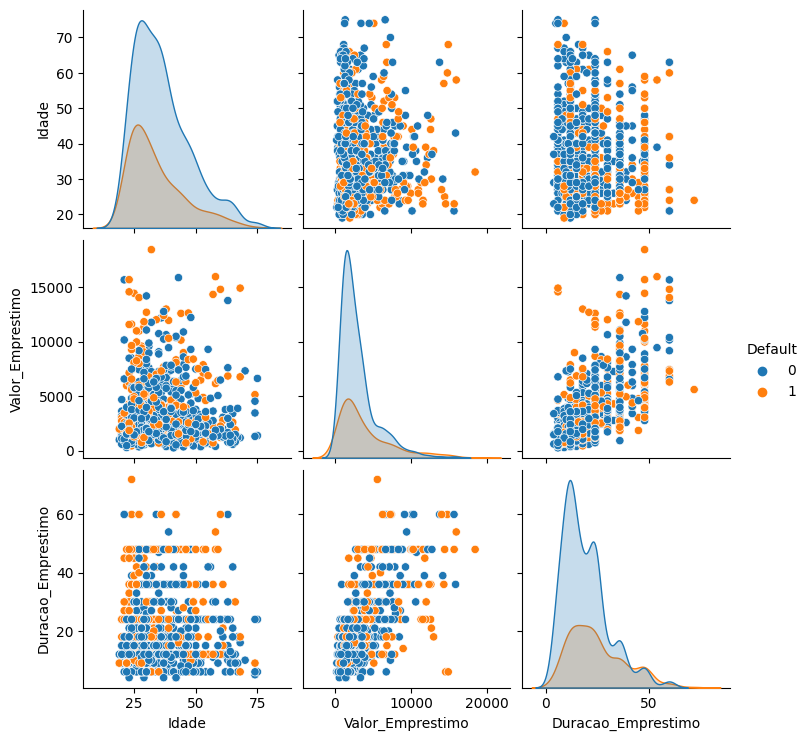

In [193]:
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')

sns.pairplot(df, hue='Default');

### Relatórios Pandas Profiling e SweetViz

In [194]:
perfil_pp, perfil_sv = preditiva.gera_relatorios_aed(df=df,
                                                     target_feat='Default')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

                                             |          | [  0%]   00:00 -> (? left)

Report base_aed_sv.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Desenvolvimento do Modelo: Árvores de Decisão

### Definição do *Target* e das *Features*

In [195]:
df.head(5)

,Idade,Genero,Escolaridade,Tipo_Moradia,Saldo_Investimento,Saldo_Conta_Corrente,Valor_Emprestimo,Duracao_Emprestimo,Default
0,67,M,Graduacao,Propria,Sem investimento,Pouco,1169,6,0
1,22,H,Graduacao,Propria,Pouco,Moderado,5951,48,1
2,49,M,Pos Graduacao,Propria,Pouco,Sem conta,2096,12,0
3,45,M,Graduacao,De favor,Pouco,Pouco,7882,42,0
4,53,M,Graduacao,De favor,Pouco,Pouco,4870,24,1


In [196]:
# Target (variável resposta)
y_var = 'Default'
y = df[y_var]

# Features (variáveis explicativas)
x_var = ['Idade', 'Genero', 'Escolaridade', 'Tipo_Moradia', 
         'Saldo_Investimento','Saldo_Conta_Corrente', 
         'Valor_Emprestimo', 'Duracao_Emprestimo']
x = df[x_var]

### Separação das bases em Treino e Teste

In [197]:
df_x = pd.get_dummies(x, drop_first=True)

# Divisão em treino e teste
x_train, x_test, y_train, y_test = train_test_split(df_x, y, 
                                                    test_size=0.30,
                                                    random_state=42)

### Criação de uma função para simplificar o processo

In [198]:
def treina_arvore_classificacao(x_train, y_train, x_test, y_test, max_d, min_s):

    modelo = DecisionTreeClassifier(max_depth=max_d,
                                   min_samples_leaf=min_s,
                                   random_state=42)
    modelo.fit(x_train, y_train)
    
    desempenho = preditiva.calcula_desempenho(modelo,
                                              x_train, y_train,
                                              x_test, y_test)
    
    desempenho['Max Depth'] = max_d
    desempenho['Min Samples Leaf'] = min_s
    desempenho.reset_index(inplace=True)
    desempenho.rename(columns={'index':'metrica'}, inplace=True)
    
    return modelo, desempenho

In [199]:
modelo, desempenho = treina_arvore_classificacao(x_train, y_train, x_test, y_test, 2, 5)

In [200]:
desempenho

,metrica,Treino,Teste,Variação,Max Depth,Min Samples Leaf
0,Acurácia,0.732857,0.710000,-0.03,2,5
1,AUROC,0.707598,0.716231,0.01,2,5
2,KS,0.325086,0.395867,0.22,2,5
3,Precision,0.634146,0.562500,-0.11,2,5
4,Recall,0.248804,0.197802,-0.20,2,5
5,F1,0.357388,0.292683,-0.18,2,5


In [201]:
max_d = list()
min_s = list()
desempenho = pd.DataFrame()

for d in range(1,5):
    for s in range(1, 31):
        max_d.append(d)
        min_s.append(s)
        modelo, desemp = treina_arvore_classificacao(x_train, y_train, 
                                     x_test, y_test, 
                                     d, s)
        desempenho = pd.concat([desempenho, desemp], axis=0)
        
desempenho.head(6)

,metrica,Treino,Teste,Variação,Max Depth,Min Samples Leaf
0,Acurácia,0.701429,0.696667,-0.01,1,1
1,AUROC,0.660667,0.697934,0.06,1,1
2,KS,0.321334,0.395867,0.23,1,1
3,Precision,0.000000,0.000000,NaN,1,1
4,Recall,0.000000,0.000000,NaN,1,1
5,F1,0.000000,0.000000,NaN,1,1


In [202]:
# Transformação dos DataFrames
# Treino
desemp_treino = pd.pivot(data=desempenho, 
                         index=['Max Depth','Min Samples Leaf'], 
                         columns='metrica', values='Treino')
desemp_treino.rename(columns={
    'AUROC':'AUROC_Treino', 
    'Acurácia':'Acurácia_Treino',
    'F1':'F1_Treino',
    'KS':'KS_Treino',
    'Precision':'Precision_Treino',
    'Recall':'Recall_Treino'
    }, inplace=True)

# Teste
desemp_teste = pd.pivot(data=desempenho, 
                        index=['Max Depth','Min Samples Leaf'], 
                        columns='metrica', values='Teste')
desemp_teste.rename(columns={
    'AUROC':'AUROC_Teste', 
    'Acurácia':'Acurácia_Teste',
    'F1':'F1_Teste',
    'KS':'KS_Teste',
    'Precision':'Precision_Teste',
    'Recall':'Recall_Teste'
    }, inplace=True)

# Variação
desemp_variacao = pd.pivot(data=desempenho, 
                           index=['Max Depth','Min Samples Leaf'], 
                           columns='metrica', values='Variação')
desemp_variacao.rename(columns={
    'AUROC':'AUROC_Variacao', 
    'Acurácia':'Acurácia_Variacao',
    'F1':'F1_Variacao',
    'KS':'KS_Variacao',
    'Precision':'Precision_Variacao',
    'Recall':'Recall_Variacao'
    }, inplace=True)

In [203]:
busca_ad = pd.concat([desemp_treino, desemp_teste, desemp_variacao], axis=1)
busca_ad.reset_index(inplace=True)
busca_ad.head()

metrica,Max Depth,Min Samples Leaf,AUROC_Treino,Acurácia_Treino,F1_Treino,KS_Treino,Precision_Treino,Recall_Treino,AUROC_Teste,Acurácia_Teste,F1_Teste,KS_Teste,Precision_Teste,Recall_Teste,AUROC_Variacao,Acurácia_Variacao,F1_Variacao,KS_Variacao,Precision_Variacao,Recall_Variacao
0,1,1,0.660667,0.701429,0.0,0.321334,0.0,0.0,0.697934,0.696667,0.0,0.395867,0.0,0.0,0.06,-0.01,NaN,0.23,NaN,NaN
1,1,2,0.660667,0.701429,0.0,0.321334,0.0,0.0,0.697934,0.696667,0.0,0.395867,0.0,0.0,0.06,-0.01,NaN,0.23,NaN,NaN
2,1,3,0.660667,0.701429,0.0,0.321334,0.0,0.0,0.697934,0.696667,0.0,0.395867,0.0,0.0,0.06,-0.01,NaN,0.23,NaN,NaN
3,1,4,0.660667,0.701429,0.0,0.321334,0.0,0.0,0.697934,0.696667,0.0,0.395867,0.0,0.0,0.06,-0.01,NaN,0.23,NaN,NaN
4,1,5,0.660667,0.701429,0.0,0.321334,0.0,0.0,0.697934,0.696667,0.0,0.395867,0.0,0.0,0.06,-0.01,NaN,0.23,NaN,NaN


In [204]:
def analise_hiperparametro(hp, metrica):
    sns.set_theme()

    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    fig.suptitle(t='Análise do Hiperparâmetro: ' + hp, fontsize=12)

    sns.lineplot(ax=axes[0], x=busca_ad[hp], y=busca_ad[f'{metrica}_Treino'], label='Treino')
    sns.lineplot(ax=axes[0], x=busca_ad[hp], y=busca_ad[f'{metrica}_Teste'], label='Teste', color='orange')
    axes[0].legend()

    sns.lineplot(ax=axes[1], x=busca_ad[hp], y=busca_ad[f'{metrica}_Variacao'],
                 color='g')

    fig.tight_layout()

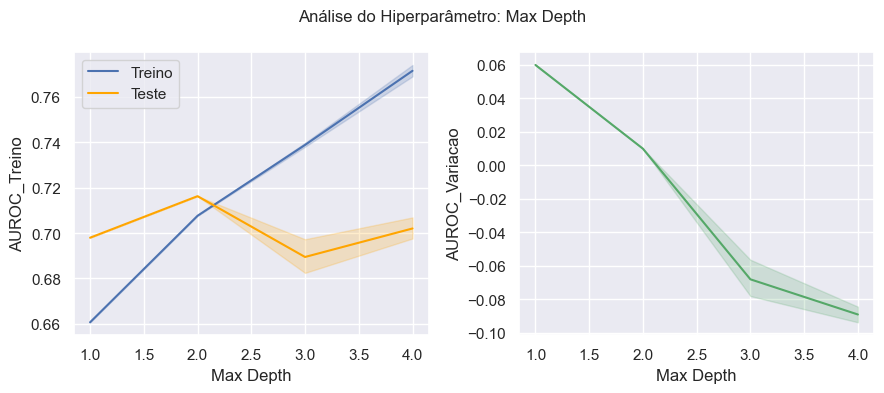

In [205]:
analise_hiperparametro('Max Depth', 'AUROC')

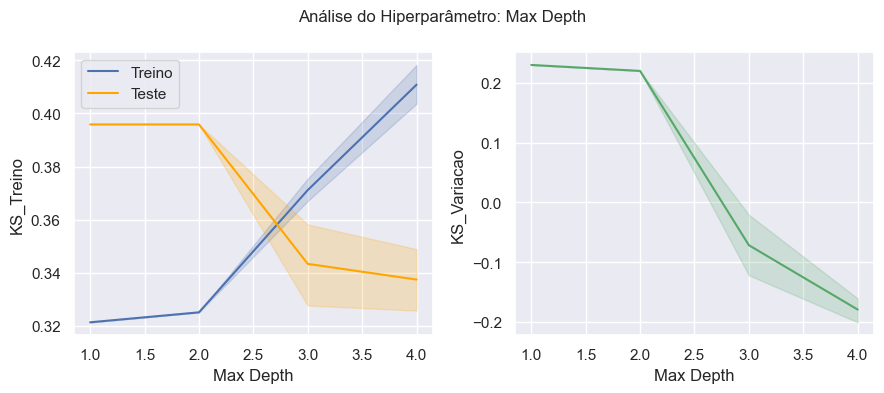

In [206]:
analise_hiperparametro('Max Depth', 'KS')

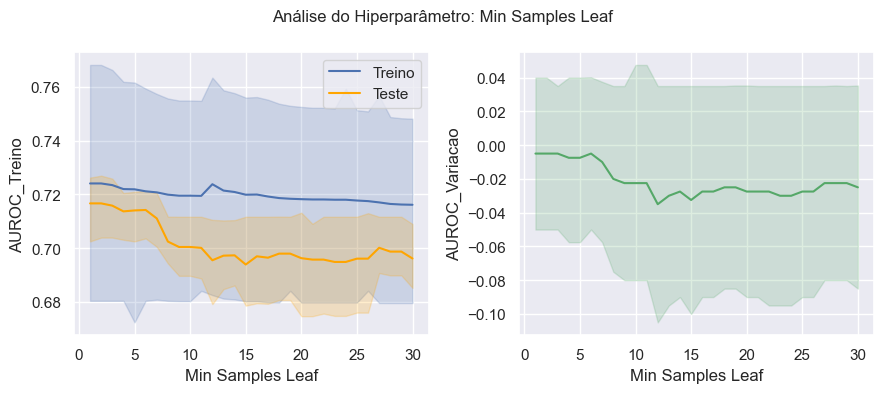

In [207]:
analise_hiperparametro('Min Samples Leaf', 'AUROC')

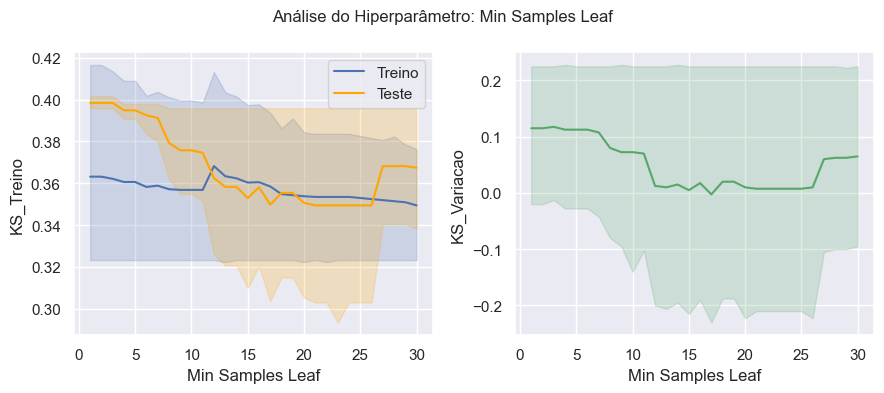

In [208]:
analise_hiperparametro('Min Samples Leaf', 'KS')

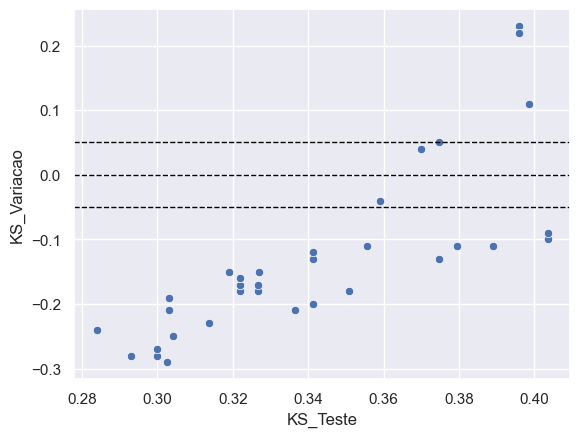

In [209]:
desemp_graf = sns.scatterplot(x=busca_ad['KS_Teste'], 
                              y=busca_ad['KS_Variacao'])
ax1 = desemp_graf.axes
ax1.axhline( 0, color='black', ls='--', linewidth = 1)
ax1.axhline(-0.05, color='black', ls='--', linewidth = 1)
ax1.axhline( 0.05, color='black', ls='--', linewidth = 1)
plt.show()

In [210]:
analise_hp = busca_ad.loc[
    (busca_ad['KS_Variacao'] >= -0.05) &
    (busca_ad['KS_Variacao'] <=  0.05) &
    (busca_ad['KS_Teste'] > 0.35)
    ].copy()

analise_hp['KS_VariacaoABS'] = abs(analise_hp['KS_Variacao'])

analise_hp.sort_values(by=['KS_VariacaoABS', 'KS_Teste', 'Min Samples Leaf', 'Max Depth'],
                  ascending=[True, False, False, True])\
    [['Max Depth','Min Samples Leaf','KS_Treino','KS_Teste','KS_Variacao']]

metrica,Max Depth,Min Samples Leaf,KS_Treino,KS_Teste,KS_Variacao
70,3,11,0.356347,0.369998,0.04
69,3,10,0.356347,0.369998,0.04
68,3,9,0.356347,0.369998,0.04
89,3,30,0.373995,0.359009,-0.04
88,3,29,0.373995,0.359009,-0.04
87,3,28,0.373995,0.359009,-0.04
86,3,27,0.373995,0.359009,-0.04
67,3,8,0.355636,0.374783,0.05


#### Modelo Selecionado: Max Depth=3, Min Samples Leaf=11

In [211]:
modelo_d3s11, desemp_d3s11 = treina_arvore_classificacao(x_train, y_train,
                                                         x_test, y_test, 
                                                         3, 11)
desemp_d3s11

,metrica,Treino,Teste,Variação,Max Depth,Min Samples Leaf
0,Acurácia,0.752857,0.723333,-0.04,3,11
1,AUROC,0.739186,0.701930,-0.05,3,11
2,KS,0.356347,0.369998,0.04,3,11
3,Precision,0.695652,0.617647,-0.11,3,11
4,Recall,0.306220,0.230769,-0.25,3,11
5,F1,0.425249,0.336000,-0.21,3,11


### Avaliação do modelo treinado

#### Interpretação do Modelo

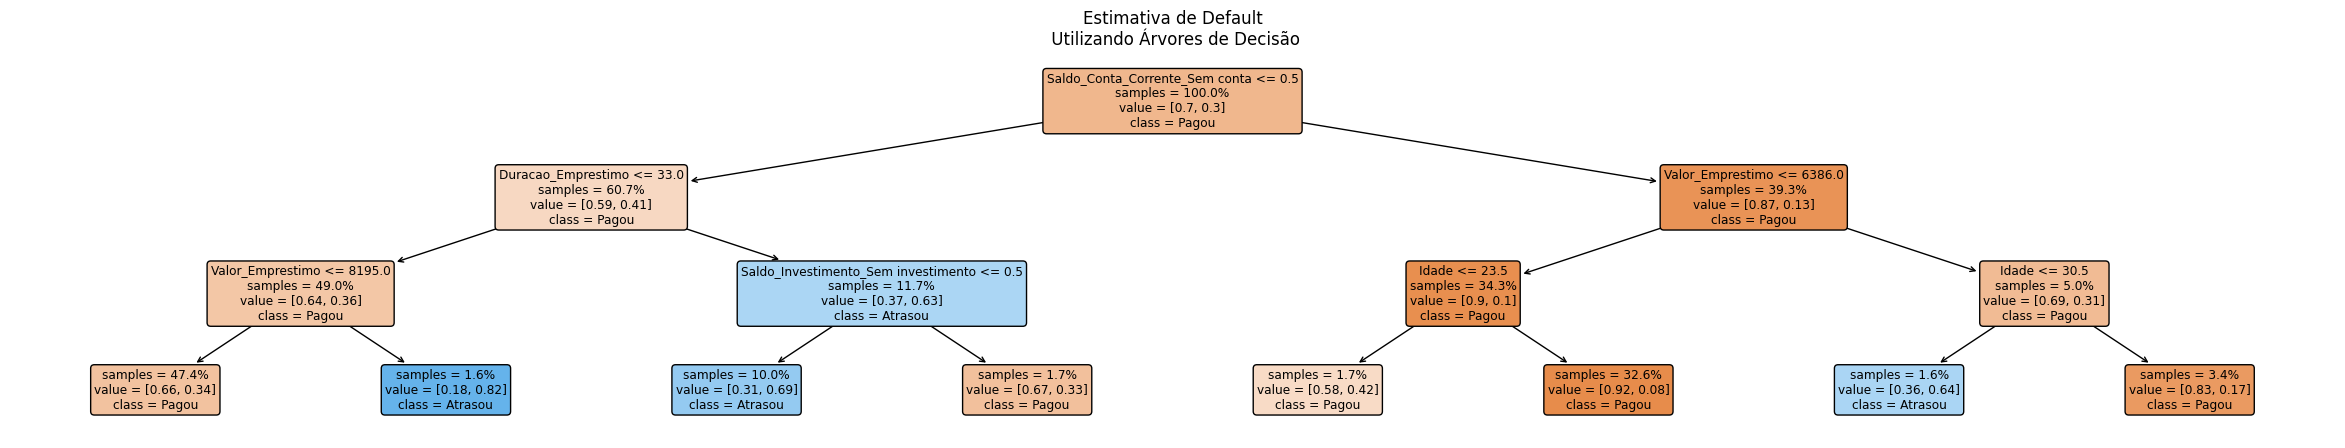

In [212]:
sns.reset_defaults()
%matplotlib inline

fig = plt.figure(figsize=(30,5))
features = list(df_x.columns)
class_names = ['Pagou','Atrasou']
tree.plot_tree(modelo_d3s11,
               feature_names=features, 
               class_names=class_names,
               rounded=True, 
               precision=2,
               proportion=True,
               impurity=False,
               filled=True);
plt.title("Estimativa de Default\n Utilizando Árvores de Decisão");

In [213]:
%matplotlib inline
viz = dtreeviz.model(model=modelo_d3s11, 
               X_train=df_x, y_train=y, 
               target_name='Default',
               class_names=class_names,
               feature_names=features)

/home/lucasmateus/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


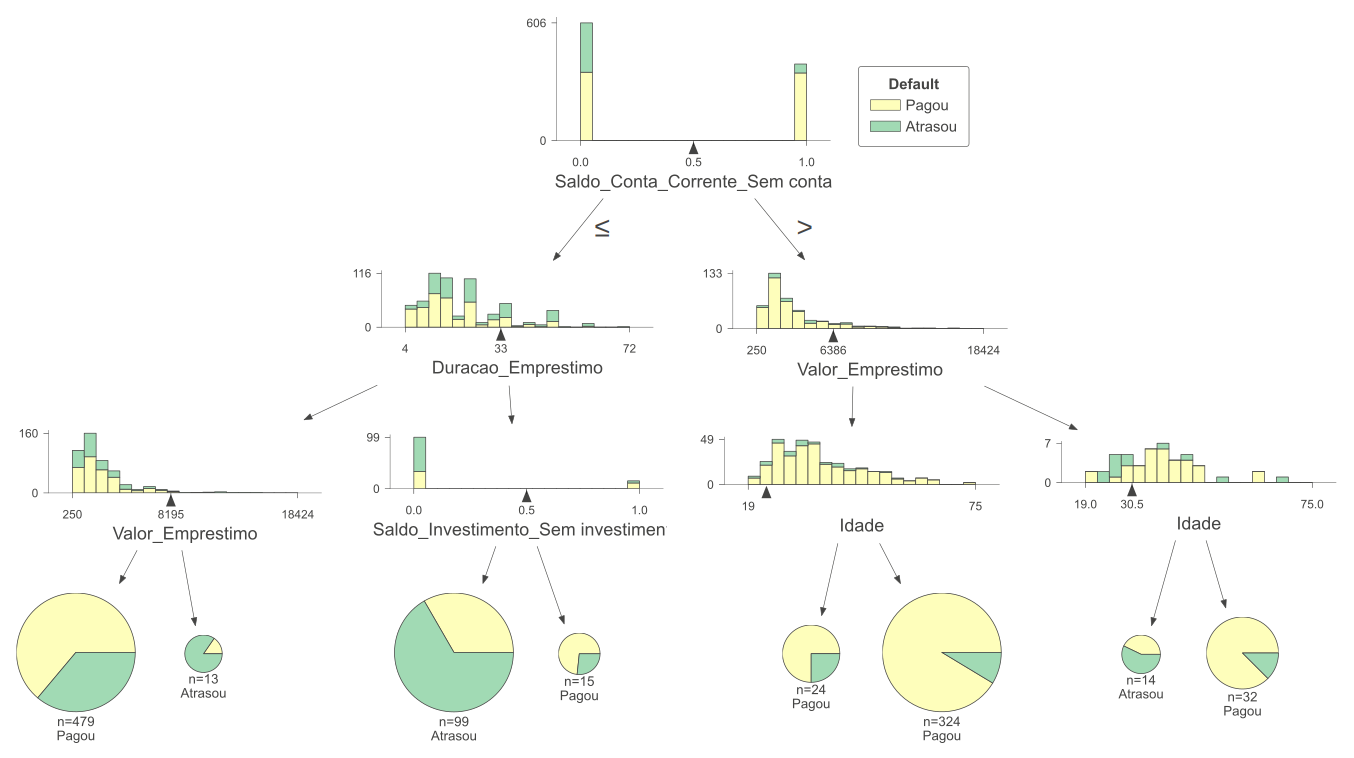

In [214]:
viz.view(scale=2.0)

## Desenvolvimento do Modelo: Regressão Logística

In [215]:
# Divisão em treino e teste
x_train, x_test, y_train, y_test = train_test_split(df_x, y, 
                                                    test_size=0.30,
                                                    random_state=42)

In [216]:
# Define modelo de Regressão Logística
modelo_rlog = LogisticRegression(random_state=42, 
                                    fit_intercept=True,
                                    solver='liblinear'
                                    )

# Ajusta o modelo
modelo_rlog.fit(x_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [217]:
modelo_rlog.coef_

array([[-3.08696499e-02,  3.95625744e-05,  2.72437834e-02,
        -3.52009521e-01, -8.81612249e-02, -1.08523807e-01,
         4.66578150e-01, -3.47759312e-01,  4.11175697e-01,
         5.65905907e-01,  2.68452587e-01,  6.89412286e-01,
         9.85998037e-01, -6.78871218e-01]])

In [218]:
# Calcula desempenho da Regressão Logística
preditiva.calcula_desempenho(modelo_rlog, x_train, y_train, x_test, y_test)

,Treino,Teste,Variação
Acurácia,0.755714,0.723333,-0.04
AUROC,0.771037,0.763920,-0.01
KS,0.442238,0.445292,0.01
Precision,0.643939,0.576923,-0.10
Recall,0.406699,0.329670,-0.19
F1,0.498534,0.419580,-0.16


In [219]:
desemp_d3s11

,metrica,Treino,Teste,Variação,Max Depth,Min Samples Leaf
0,Acurácia,0.752857,0.723333,-0.04,3,11
1,AUROC,0.739186,0.701930,-0.05,3,11
2,KS,0.356347,0.369998,0.04,3,11
3,Precision,0.695652,0.617647,-0.11,3,11
4,Recall,0.306220,0.230769,-0.25,3,11
5,F1,0.425249,0.336000,-0.21,3,11
